In [1]:
#Import packages
import pandas as pd
from  plotnine import *

In [2]:
#Instruct Jupyter to display plots inline
%matplotlib inline

## 1. Loading the data into Python

In [3]:
#Read the WaterUse and Population worksheets into data frames
dfWaterUse = pd.read_excel('../data/State_Data_Formatted.xlsx','WaterUse')
dfPopulation = pd.read_excel('../data/State_Data_Formatted.xlsx','Population')

## 2. Joining tables

In [4]:
#Join the tables
dfAll = pd.merge(left=dfWaterUse,
                 right=dfPopulation,
                 how='inner',
                 left_on = 'State',
                 right_on = 'STATE'
                )
dfAll.head()

,State,Source,Type,Category,Withdrawal_MGD,STATE,Population_Thousands,Population
0,Alabama,Surface,Fresh,Total,9470.0,Alabama,4780,4780000
1,Alabama,Groundwater,Fresh,Total,494.0,Alabama,4780,4780000
2,Alabama,Surface,Saline,Total,0.0,Alabama,4780,4780000
3,Alabama,Groundwater,Saline,Total,0.0,Alabama,4780,4780000
4,Alabama,Surface,Fresh,Public Supply,551.0,Alabama,4780,4780000


## 3. Construct the visualization
Recall the Tableau stacked bar plot of water withdrawal by type and category:
![Plot1](https://datadevils.github.io/DataBootCamp/media/tableau/StackedBarPlot1.PNG)
Here we recreate the same plot using Plotnine's ggplot interface

### 3a. Organizing our data
In Tableau, we had to organize our data. Here, our data exist in a tidy format (one and only one row for each observation, with a column for each property of that observation). `ggplot` is designed to work with data in that format, so no need to further organize our data!

### 3b. Plotting our data
The next step is to construct our plots, which we will be doing with the `Plotnine` package. This package enables us to use the`ggplot` interface, which has a bit of a steep learning curve. So, let's pause and introduce the grammer of graphics...

### ►`ggplot` _and the Grammer of Graphics_ ◄
Plots have numerous options in presentation, design, and content. The Grammer of Graphics ("GG") is a set of structural rules defining the components of a plotting language that strives to simplify designing plots from such a wide array of options from a coding platform. Even so, it has a bit of a steep learning curve, so to help with that, let's examine it from it's foundations. 

This image (from https://towardsdatascience.com) represents the major components of GG: 
![GG components](https://miro.medium.com/max/1920/1*mcLnnVdHNg-ikDbHJfHDNA.png)

* At its base are the **data** that drives our plot, which makes sense and also underscores the importance that our data is in a tidy format.
* Above that are the **aesthetics** which define what columns include the data we want to plot and how we want to plot them. 

Let's begin with just those two elements: 

In [10]:
#Plot
g = ggplot(data=dfAll,mapping=aes(x='Category',y='Withdrawal_MGD',fill='Source'))
g + geom_bar()

PlotnineError: 'stat_count() must not be used with a y aesthetic'

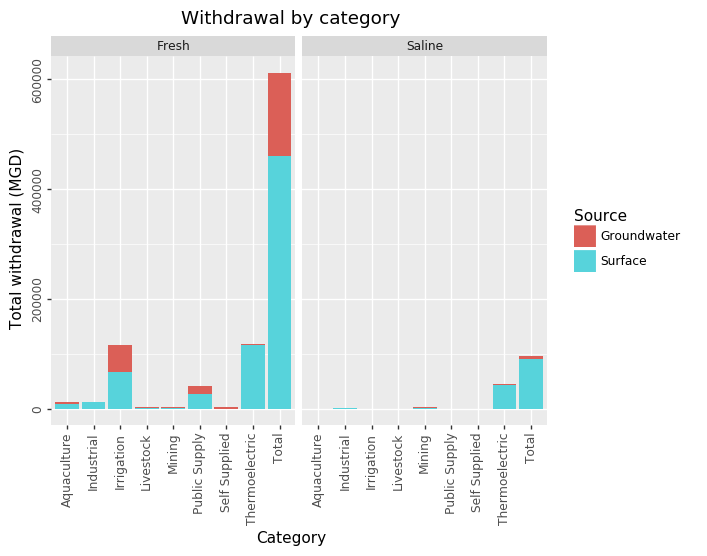

<ggplot: (134064262741)>

In [6]:
(ggplot(data=dfAll,mapping=aes(x='Category',y='Withdrawal_MGD',fill='Source')) +
  geom_col() +
  facet_wrap(facets = 'Type') + 
  theme(axis_text = element_text(angle=90)) +
  ggtitle('Withdrawal by category') + 
  ylab('Total withdrawal (MGD)')
)

![Transposed](https://datadevils.github.io/DataBootCamp/media/tableau/StackedBarPlot2.PNG)

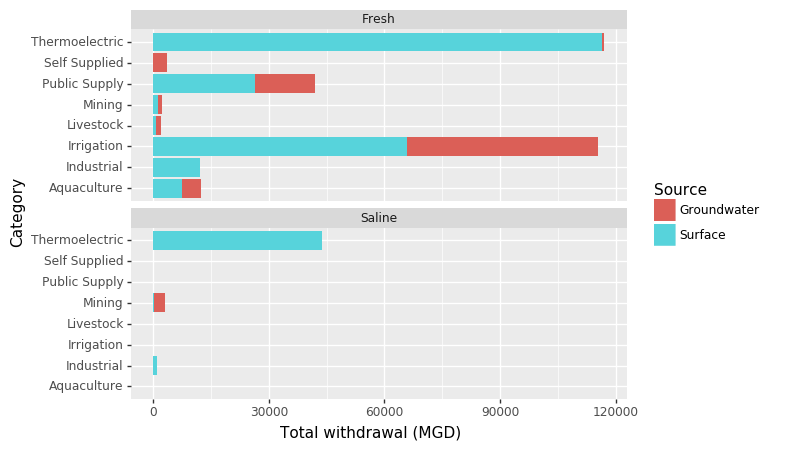

<ggplot: (191199181327)>

In [30]:
(ggplot(data=dfAll[dfAll.Category != 'Total'],
        mapping=aes(x='Category',y='Withdrawal_MGD',fill='Source')) +
  geom_col() +
  coord_flip() +
  facet_wrap(facets = 'Type',ncol=1) + 
  ylab('Total withdrawal (MGD)') +
  theme(axis_text = element_text(angle=0)) 
)

### 3c. Filter for just Fresh

C:\Users\jpfay\AppData\Local\ESRI\conda\envs\bootcamp\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


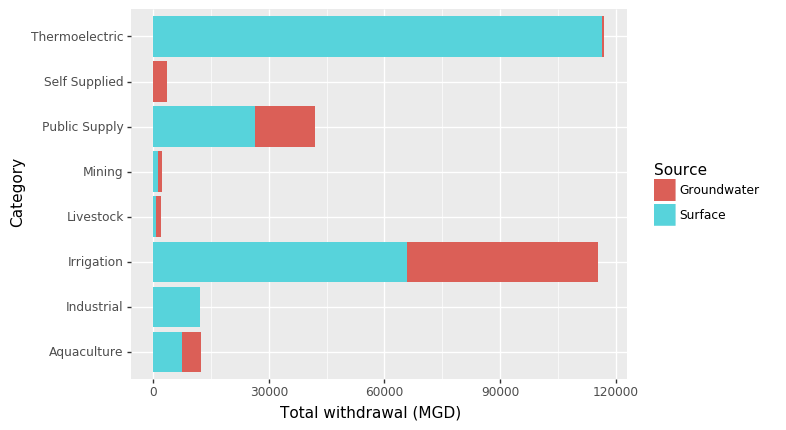

<ggplot: (191199181418)>

In [39]:
df_Fresh = dfAll.query('Type == "Fresh"')
df_Fresh.index = 
(ggplot(data=df_Fresh[dfAll.Category != 'Total'],
        mapping=aes(x='Category',y='Withdrawal_MGD',fill='Source')) +
  geom_col() +
  coord_flip() +
  #facet_wrap(facets = 'Type',ncol=1) + 
  ylab('Total withdrawal (MGD)') +
  theme(axis_text = element_text(angle=0)) 
)